In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import ecco_v4_py as ecco

import cmocean.cm as cmo
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Import ECCO dataset

In [2]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/').rename({'face': 'tile'})

In [10]:
grid = ecco.get_llc_grid(main)

### Useful quantities

In [3]:
# Density kg/m^3
rhoconst = 1029

# Heat capacity (J/kg/K)
c_p = 3994

# Watts to Petawatts
pw = 1e-15

# m^3 to Sverdrup
Sv = 10**-6

In [4]:
# Volume (m^3)
vol = (main.rA*main.drF*main.hFacC)

### Define the section lines 

In [5]:
pt1,pt2 = ecco.get_section_endpoints('Labrador Greenland')

maskC, maskW, maskS = ecco.get_section_line_masks(pt1,pt2,main)

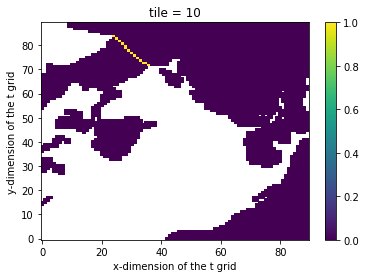

In [12]:
maskC[10].where(main.hFacC[0,10].values==1).plot()

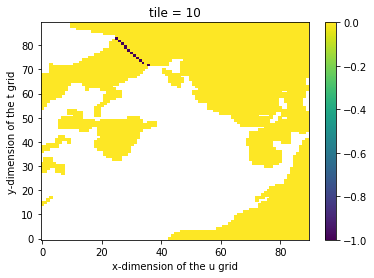

In [13]:
maskW[10].where(main.hFacW[0,10].values==1).plot()

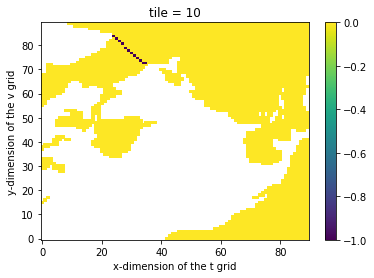

In [14]:
maskS[10].where(main.hFacS[0,10].values==1).plot()

### Grid area along section

**$X$**: ds.UVELMASS
`hFacW`, `maskW`
- Tile 2: zonal
- Tile 6: meridional
- Tile 10: meridional

**$Y$**: ds.VVELMASS
`hFacS`, `maskS`
- Tile 2: meridional
- Tile 6: zonal
- Tile 10: zonal

In [6]:
# Cell area along y at u location (m^2)
dyA = main.dyG*main.drF*main.hFacW

# Cell area along x at v location (m^2)
dxA = main.dxG*main.drF*main.hFacS

In [7]:
# Get area for Davis Strait
dyA_LG = dyA*maskW*-1
dxA_LG = dxA*maskS*-1

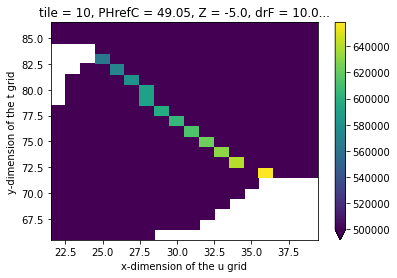

In [139]:
dyA_LG[10,:,:,0].where(main.hFacW[0,10].values==1)[66:87,22:40].plot(vmin=5e5)

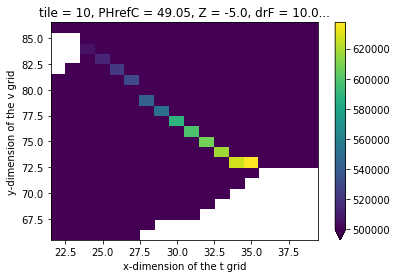

In [142]:
dxA_LG[10,:,:,0].where(main.hFacS[0,10].values==1)[66:87,22:40].plot(vmin=5e5)

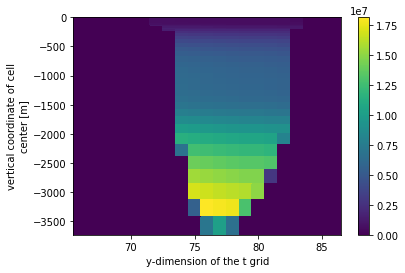

In [34]:
dyA_LG.sum(dim=['i_g','tile'])[66:87,:].T.swap_dims({'k':'Z'})[:44].plot()

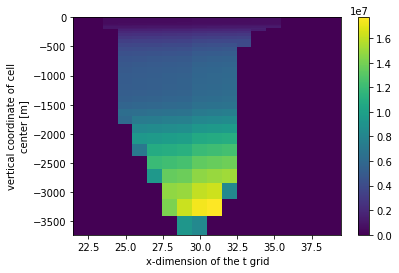

In [35]:
dxA_LG.sum(dim=['j_g','tile'])[22:40,:].T.swap_dims({'k':'Z'})[:44].plot()

In [36]:
sec_area_x = dyA_LG.sum(dim=['i_g','j','tile'])
sec_area_y = dxA_LG.sum(dim=['i','j_g','tile'])

In [40]:
# Section area (m^2)
sec_area = (sec_area_x + sec_area_y).sum('k').compute()

print('Area of the Labrador-Greenland transect:',np.round(sec_area.values/1e6),'km^2')

Area of the Labrador-Greenland transect: 3091.0 km^2


### Volume flux

In [41]:
u_transport = (main['UVELMASS'] + main['UVELSTAR']) * main['drF'] * main['dyG']
v_transport = (main['VVELMASS'] + main['VVELSTAR']) * main['drF'] * main['dxG']

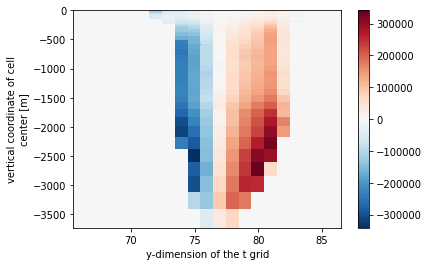

In [43]:
(u_transport * maskW).sum(dim=['i_g','tile']).mean('time')[:,66:87].swap_dims({'k':'Z'})[:44].plot()

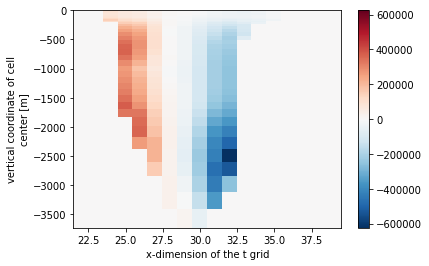

In [44]:
(v_transport * maskS).sum(dim=['j_g','tile']).mean('time')[:,22:40].swap_dims({'k':'Z'})[:44].plot()

In [45]:
# Volume transports
sec_trsp_x = (u_transport * maskW).sum(dim=['i_g','j','tile'])
sec_trsp_y = (v_transport * maskS).sum(dim=['i','j_g','tile'])

In [143]:
sec_trsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()*Sv

print('Volume flux (1992-2015):', 
      np.round(sec_trsp.mean('time').values,2),'±',np.round(2*sec_trsp.std('time').values,2),'Sv')

Volume flux (1992-2015): -1.61 ± 0.63 Sv


- Hudson Strait: 0.03 ± 0.1 Sv
- Davis Strait: -1.6 ± 0.6 Sv

### Heat flux

In [8]:
xheat  = main.ADVx_TH.sum('k').mean('time').where(main.hFacW[0].values==1)*rhoconst*c_p*pw
yheat  = main.ADVy_TH.sum('k').mean('time').where(main.hFacS[0].values==1)*rhoconst*c_p*pw

In [11]:
xheat.coords['XW'] = grid.interp(main.XC, 'X', boundary='extend')
xheat.coords['YW'] = grid.interp(main.YC, 'X', boundary='extend')

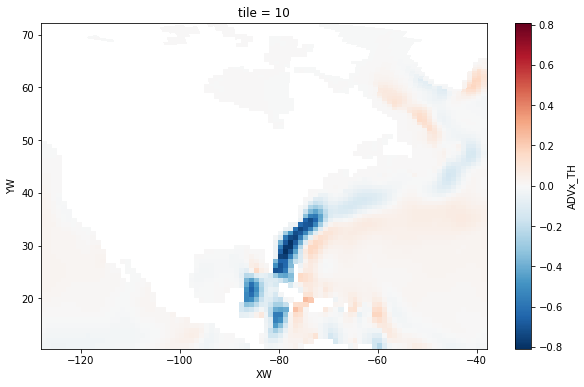

In [188]:
fig, ax = plt.subplots(figsize=(10,6))
xheat[10].where(main.hFacW[0,10].values==1).plot(ax=ax, x='XW', y='YW')

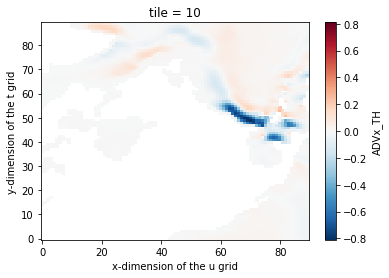

In [89]:
xheat[10].plot()

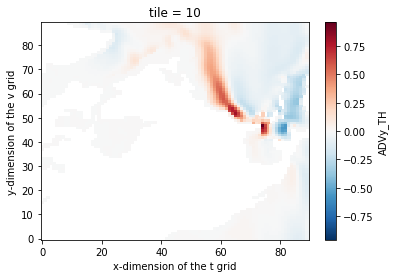

In [135]:
yheat[10].plot()

In [60]:
THETA_LG = ((main.THETA*maskC).where((maskC==1)&(main.hFacC[0].values==1))*vol).sum(dim=['tile','j'])
vol_LG = (vol*maskC).where((maskC==1)&(main.hFacC[0].values==1)).sum(dim=['tile','j'])

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


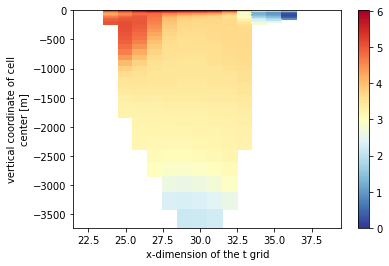

In [62]:
(THETA_LG/vol_LG).mean('time')[:,22:40].swap_dims({'k':'Z'})[:44].plot(vmin=0,cmap='RdYlBu_r')

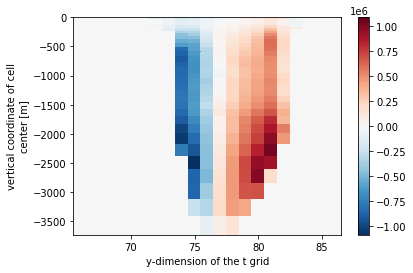

In [75]:
(main.ADVx_TH * maskW).sum(dim=['i_g','tile']).mean('time')[:,66:87].swap_dims({'k':'Z'})[:44].plot()

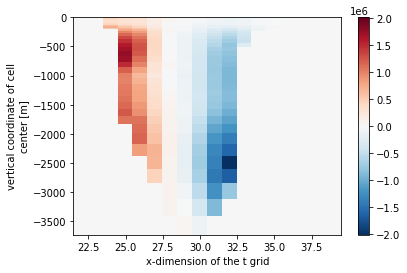

In [76]:
(main.ADVy_TH * maskS).sum(dim=['j_g','tile']).mean('time')[:,22:40].swap_dims({'k':'Z'})[:44].plot()

In [12]:
# Heat transport
sec_THtrsp_x = (main.ADVx_TH * maskW).sum(dim=['i_g','j','tile'])
sec_THtrsp_y = (main.ADVy_TH * maskS).sum(dim=['i','j_g','tile'])

In [13]:
sec_THtrsp = (sec_THtrsp_x + sec_THtrsp_y).sum('k').compute()

In [14]:
heat_trsp = sec_THtrsp*rhoconst*c_p*pw*1000

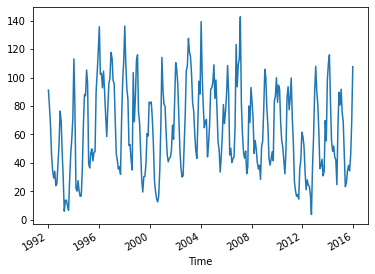

In [84]:
heat_trsp.plot()

In [85]:
print('Heat flux (1992-2015):', 
      np.round(heat_trsp.mean('time').values,1),'±',np.round(2*heat_trsp.std('time').values,1),'TW')

Heat flux (1992-2015): 63.7 ± 60.3 TW


#### Vector plot

In [90]:
x, y = np.meshgrid(np.arange(0,90,1),np.arange(0,90,1))

(50.0, 90.0)

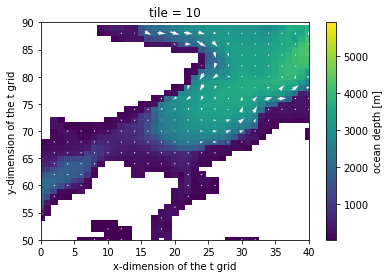

In [119]:
main.Depth[10].where(main.hFacC[0,10].values==1).plot()
plt.quiver(x[::2, ::2], y[::2, ::2], xheat[10][::2, ::2], yheat[10][::2, ::2],color='w' ,pivot='mid',scale=5,width=5e-3)

plt.xlim([0,40])
plt.ylim([50,90])

In [123]:
heat_trp = xr.DataArray(np.sqrt(np.square(xheat[10].values)+np.square(yheat[10].values)),
                        coords=[np.arange(0,90,1),np.arange(0,90,1)],dims=['j','i'])

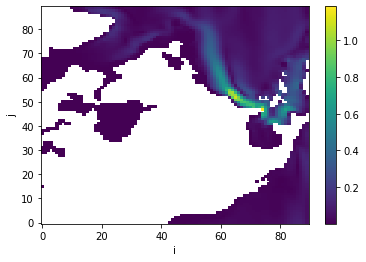

In [124]:
heat_trp.plot()

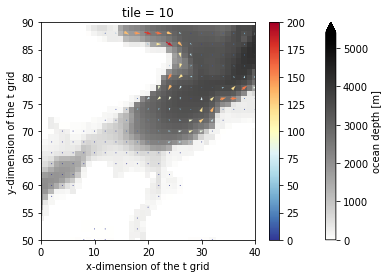

In [134]:
main.Depth[10].where(main.hFacC[0,10].values==1).plot(vmin=0, vmax=5400, cmap=cmo.gray_r)

plt.quiver(x[::2, ::2], y[::2, ::2], xheat[10][::2, ::2], yheat[10][::2, ::2],heat_trp[::2, ::2]*1000,
           pivot='mid',scale=5,width=5e-3,cmap='RdYlBu_r')

plt.xlim([0,40])
plt.ylim([50,90])

plt.colorbar()
plt.clim(0,200)

#### Heat flux at the LG transect

In [69]:
coords_LG = [-56.0, 53.69125,-55.0, 53.69125,-55.0, 54.264557,-55.0 ,54.829044,-54.0,54.829044,-54.0,55.384766,
             -53.0 , 55.384766,-53.0 , 55.931786,-52.0 , 55.931786,-52.0 , 56.470177,-51.0 , 56.470177,-51.0 , 57.0,
             -50.0 , 57.0,-49.997044 , 57.494728,-48.9972 , 57.491325,-48.98871 , 57.978825,-47.98942 , 57.972424,
             -46.990215,57.96642,-46.9778, 58.443645,-45.979767, 58.435368,-45.9637, 58.905373,-44.967514, 58.89538,
             -44.94873 , 59.35802,-43.955177 , 59.346916,-43.93474 , 59.802036]

In [182]:
j = maskW[10].where((maskW[10].values!=0)&(main.hFacW[0,10].values==1))\
            .to_dataframe(name='maskW').dropna().reset_index().j.values

i_g = maskW[10].where((maskW[10].values!=0)&(main.hFacW[0,10].values==1))\
            .to_dataframe(name='maskW').dropna().reset_index().i_g.values
    
j_g = maskS[10].where((maskS[10].values!=0)&(main.hFacS[0,10].values==1))\
            .to_dataframe(name='maskS').dropna().reset_index().j_g.values
    
i = maskS[10].where((maskS[10].values!=0)&(main.hFacS[0,10].values==1))\
            .to_dataframe(name='maskS').dropna().reset_index().i.values

In [187]:
xc = main.XC.isel(tile=10).values[j,i_g]
yg = main.YG.isel(tile=10).values[j,i_g]
xg = main.XG.isel(tile=10).values[j_g,i]
yc = main.YC.isel(tile=10).values[j_g,i]

In [193]:
xheat_LG = ((main.ADVx_TH * maskW).sum(dim=['tile','k']).mean('time')*rhoconst*c_p*pw).values[j,i_g]*1e3
yheat_LG = ((main.ADVy_TH * maskS).sum(dim=['tile','k']).mean('time')*rhoconst*c_p*pw).values[j_g,i]*1e3

/usr/local/lib/python3.6/dist-packages/xarray/core/dataarray.py:1924: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()
/usr/local/lib/python3.6/dist-packages/xarray/core/dataarray.py:1924: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()


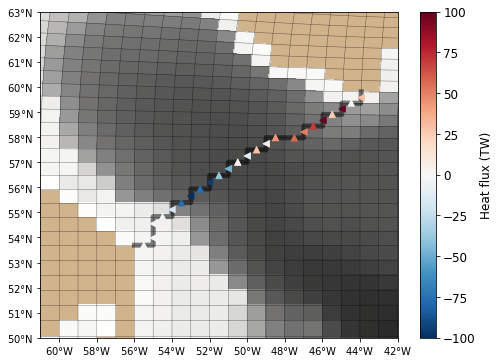

In [194]:
fig, ax = plt.subplots(figsize=(8,6))

main.Depth[10].where(main.hFacC[0,10].values==1).plot(ax=ax, x='XC', y='YC', add_colorbar=False,
                                                      vmin=0, vmax=5400, cmap=cmo.gray_r,zorder=0)
# Plot grid line
plt.plot(main.XG[10], main.YG[10],'k-',alpha=0.5,lw=0.5,zorder=0)
plt.plot(main.XG[10].T, main.YG[10].T,'k-',alpha=0.5,lw=0.5,zorder=0)

# Plot LG transect line
plt.plot(coords_LG[0::2], coords_LG[1::2], color='k',ls='-',lw=5,alpha=0.5, zorder=1)

# Plot heat flux at LG line
p = ax.scatter(xc, yg, c=xheat_LG, vmin=-100, vmax=100, cmap='RdBu_r', marker='^', s=40, zorder=2)
p = ax.scatter(xg, yc, c=yheat_LG, vmin=-100, vmax=100, cmap='RdBu_r', marker='<', s=40, zorder=2)

ax.set_xlim([-61,-42])
ax.set_ylim([50,63])
ax.set_xticks(np.arange(-60,-40,2))
ax.set_yticks(np.arange(50,64,1))
ax.set_facecolor('tan')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.set_yticklabels((r'${:.0f}\degree$N'.format(_) for _ in np.arange(50,70,1)), fontsize=10)
ax.set_xticklabels((r'${:.0f}\degree$W'.format(_) for _ in np.arange(-60,-40,2)*-1), fontsize=10)


cbar = fig.colorbar(p, ax=ax)#, ticks=np.arange(-20,25,5))
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Heat flux (TW)', fontsize=12)
plt.show()

### Divide LG transect between north and south

In [195]:
#XW = grid.interp(main.XC, 'X', boundary='extend')
YW = grid.interp(main.YC, 'X', boundary='extend')

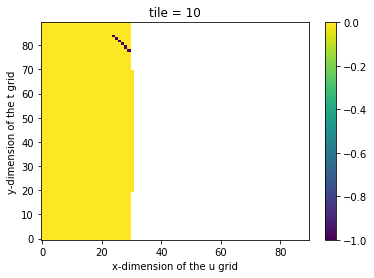

In [197]:
maskW.where(YW >= 57)[10].plot()

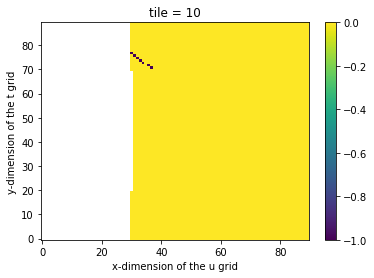

In [198]:
maskW.where(maskW.YW < 57)[10].plot()

In [201]:
YS = grid.interp(main.YC, 'Y', boundary='extend')

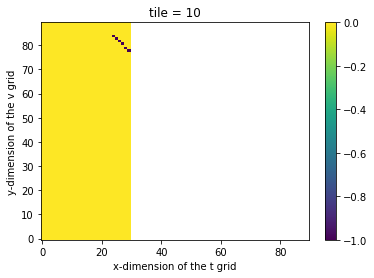

In [202]:
maskS.where(YS >= 57)[10].plot()

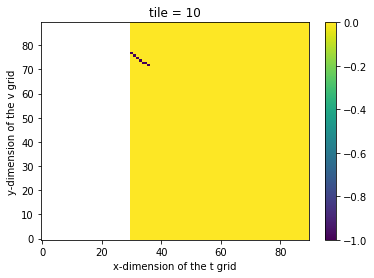

In [203]:
maskS.where(YS < 57)[10].plot()

In [210]:
sec_THtrsp_x_north = (ADVx_TH * maskW).where(YW >= 57).sum(dim=['i_g','j','tile'])
sec_THtrsp_x_south = (ADVx_TH * maskW).where(YW < 57).sum(dim=['i_g','j','tile'])

sec_THtrsp_y_north = (ADVy_TH * maskS).where(YS >= 57).sum(dim=['i','j_g','tile'])
sec_THtrsp_y_south = (ADVy_TH * maskS).where(YS < 57).sum(dim=['i','j_g','tile'])

In [212]:
sec_THtrsp_north = (sec_THtrsp_x_north + sec_THtrsp_y_north).sum('k').compute()*rhoconst*c_p*pw*1000
sec_THtrsp_south = (sec_THtrsp_x_south + sec_THtrsp_y_south).sum('k').compute()*rhoconst*c_p*pw*1000

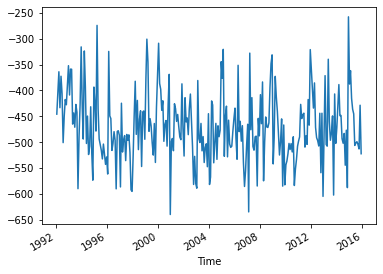

In [214]:
sec_THtrsp_south.plot()

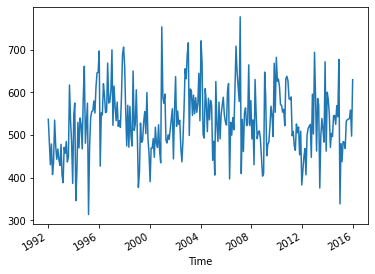

In [213]:
sec_THtrsp_north.plot()

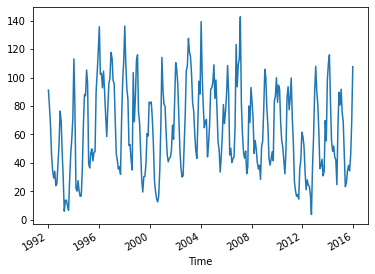

In [215]:
heat_trsp.plot()

In [216]:
from datetime import date
import matplotlib.dates as dates

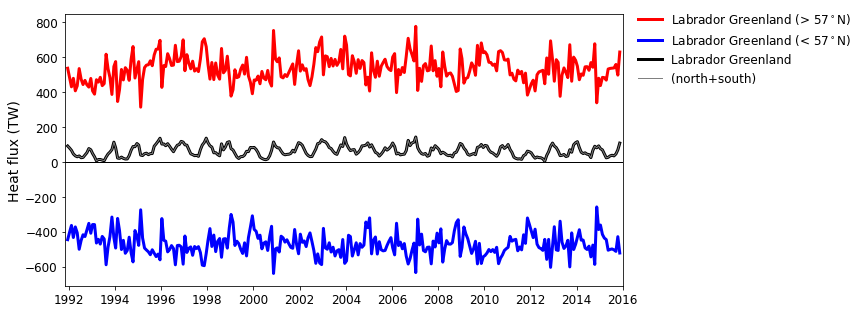

In [228]:
fig, ax = plt.subplots(figsize=(10,5))

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(sec_THtrsp_north.time, sec_THtrsp_north,color='red', lw=3, label='Labrador Greenland (> 57$^\circ}$N)')
ax.plot(sec_THtrsp_south.time, sec_THtrsp_south,color='blue', lw=3, label='Labrador Greenland (< 57$^\circ}$N)')
ax.plot(heat_trsp.time, heat_trsp,color='k', lw=3, label='Labrador Greenland')
ax.plot(heat_trsp.time, sec_THtrsp_north+sec_THtrsp_south,color='grey', lw=1, label='(north+south)')

ax.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])
ax.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Heat flux (TW)',fontsize=14)
ax.legend(loc='upper right',frameon=False,fontsize=12,bbox_to_anchor=(1.43, 1.05))

plt.show()

In [229]:
sec_THtrsp_north_anom = sec_THtrsp_north.groupby('time.month') - sec_THtrsp_north.groupby('time.month').mean('time')
sec_THtrsp_south_anom = sec_THtrsp_south.groupby('time.month') - sec_THtrsp_south.groupby('time.month').mean('time')
heat_trsp_anom = heat_trsp.groupby('time.month') - heat_trsp.groupby('time.month').mean('time')

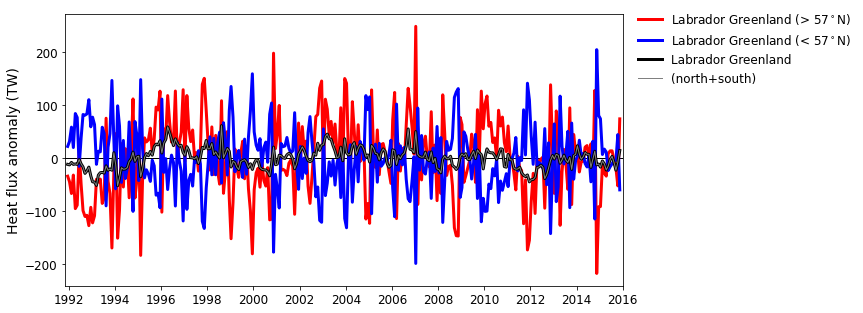

In [231]:
fig, ax = plt.subplots(figsize=(10,5))

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(sec_THtrsp_north.time, sec_THtrsp_north_anom, color='red', lw=3, label='Labrador Greenland (> 57$^\circ}$N)')
ax.plot(sec_THtrsp_south.time, sec_THtrsp_south_anom, color='blue', lw=3, label='Labrador Greenland (< 57$^\circ}$N)')
ax.plot(heat_trsp.time, heat_trsp_anom,color='k', lw=3, label='Labrador Greenland')
ax.plot(heat_trsp.time, sec_THtrsp_north_anom+sec_THtrsp_south_anom,color='grey', lw=1, label='(north+south)')

ax.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])
ax.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Heat flux anomaly (TW)',fontsize=14)
ax.legend(loc='upper right',frameon=False,fontsize=12,bbox_to_anchor=(1.43, 1.05))

plt.show()

In [250]:
df = pd.DataFrame({'time':heat_trsp.time,'total':heat_trsp_anom*1e12,
                   'north':sec_THtrsp_north_anom*1e12,'south':sec_THtrsp_south_anom*1e12})
df.set_index('time',inplace=True)

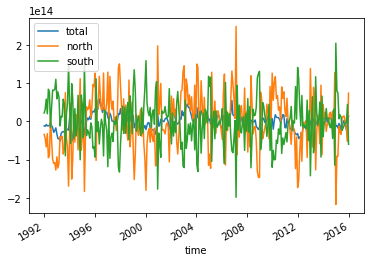

In [251]:
df.plot()

In [252]:
df['dt'] = main.reset_coords().dt.to_dataframe().dt

In [253]:
# 6-month
df_sub = df.loc[(df.index > '1992-06-30')&(df.index <= '2016-01-01')]
df_6mo = df_sub.multiply(df_sub["dt"], axis="index").resample('6M',kind='period').sum().drop(columns=['dt'])

# Annual
df_sub = df.loc[(df.index > '1992-12-31')&(df.index < '2015-01-01')]
df_1yr = df_sub.multiply(df_sub["dt"], axis="index").resample('1A',kind='period').sum().drop(columns=['dt'])

# 2-year
df_sub = df.loc[(df.index > '1992-12-31')&(df.index < '2015-01-01')]
df_2yr = df_sub.multiply(df_sub["dt"], axis="index").resample('2A',kind='period').sum().drop(columns=['dt'])

# Pentad
df_sub = df.loc[(df.index > '1994-12-31')&(df.index < '2015-01-01')]
df_5yr = df_sub.multiply(df_sub["dt"], axis="index").resample('5A',kind='period').mean().drop(columns=['dt'])

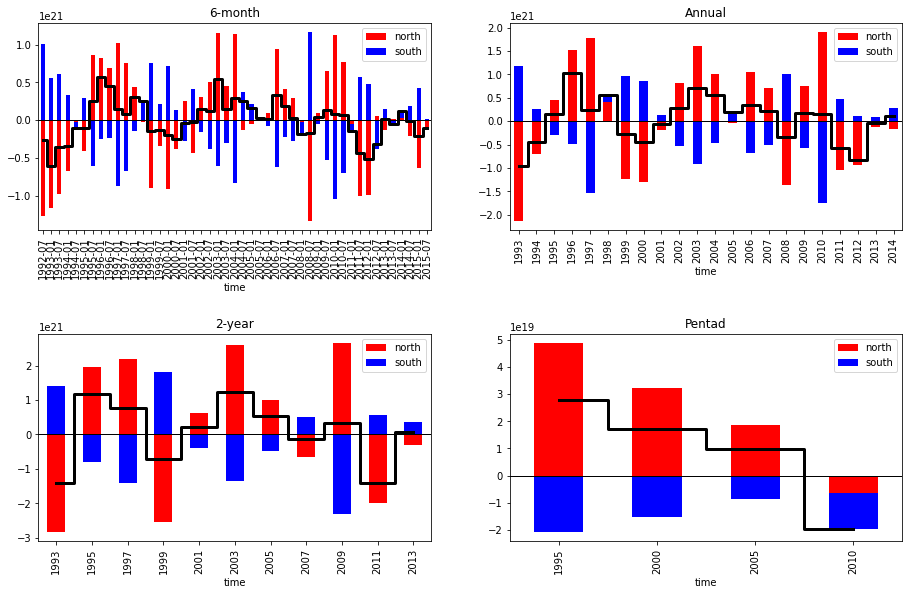

In [284]:
fig, axs = plt.subplots(2, 2, figsize=(15, 9))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.5, wspace=0.2)

df_6mo.drop(columns=['total']).plot.bar(stacked=True,color=['r','b'],ax=axs[0,0])
axs[0,0].step(df_6mo.index.strftime('%Y-%m'), df_6mo.total, where='mid', c='k', lw=3, linestyle='-')
axs[0,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,0].set_title('6-month')

df_1yr.drop(columns=['total']).plot.bar(stacked=True,color=['r','b'],ax=axs[0,1])
axs[0,1].step(df_1yr.index.strftime('%y'), df_1yr.total, where='mid', c='k', lw=3, linestyle='-')
axs[0,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,1].set_title('Annual')

df_2yr.drop(columns=['total']).plot.bar(stacked=True,color=['r','b'],ax=axs[1,0])
axs[1,0].step(df_2yr.index.strftime('%Y'), df_2yr.total, where='mid', c='k', lw=3, linestyle='-')
axs[1,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,0].set_title('2-year')

df_5yr.drop(columns=['total']).plot.bar(stacked=True,color=['r','b'],ax=axs[1,1])
axs[1,1].step(df_5yr.index.strftime('%Y'), df_5yr.total, where='mid', c='k', lw=3, linestyle='-')
axs[1,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,1].set_title('Pentad')
plt.show()

### Integrate anomalies

In [264]:
df['dt'] = main.reset_coords().dt.to_dataframe().dt

In [274]:
df_int = df.multiply(df['dt'], axis='index').cumsum().drop(columns=['dt'])

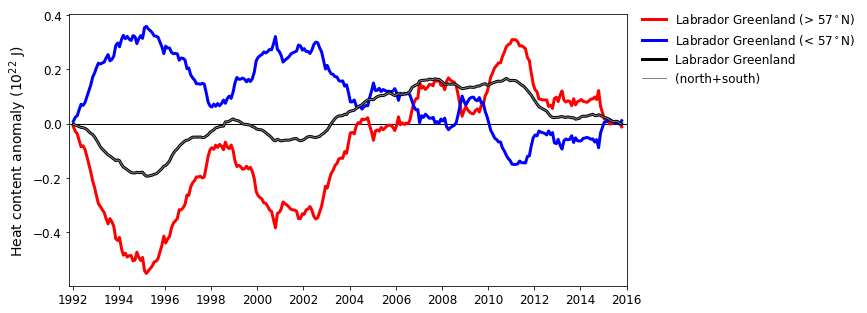

In [281]:
fig, ax = plt.subplots(figsize=(10,5))

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(df_int.index, df_int.north*1e-22, color='red', lw=3, label='Labrador Greenland (> 57$^\circ}$N)')
ax.plot(df_int.index, df_int.south*1e-22, color='blue', lw=3, label='Labrador Greenland (< 57$^\circ}$N)')
ax.plot(df_int.index, df_int.total*1e-22, color='k', lw=3, label='Labrador Greenland')
ax.plot(df_int.index, (df_int.north+df_int.south)*1e-22, color='grey', lw=1, label='(north+south)')

ax.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])
ax.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Heat content anomaly (10$^{22}$ J)',fontsize=14)
ax.legend(loc='upper right',frameon=False,fontsize=12,bbox_to_anchor=(1.43, 1.05))

plt.show()